# Redes Neuronales (MLPRegressor)

Este notebook implementa un modelo de Redes Neuronales (Multi-Layer Perceptron) para predecir la popularidad de canciones.

## Objetivo
Implementar y evaluar un modelo de Redes Neuronales, comparando su desempeño en la tarea de predicción de popularidad.

In [41]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos

Cargamos los datos con feature engineering aplicado.

In [42]:
# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datos con feature engineering
train_path = DATA / "train_fe.csv"
test_path = DATA / "test_fe.csv"

assert train_path.exists(), f"No se encontró {train_path}"
assert test_path.exists(), f"No se encontró {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas disponibles:")
print(train.columns.tolist())

✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 17)

Columnas disponibles:
['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2. Preparación de Datos

Separamos las características (X) de la variable objetivo (y) y eliminamos columnas no relevantes.

In [48]:
# Variable objetivo
target_col = "popularity"

# Separar características y variable objetivo
X_train_full = train.drop(columns=[target_col, "track_id"])  # Eliminar track_id (identificador)
y_train_full = train[target_col]

# Preparar test (sin track_id e id)
# Nota: test_fe.csv tiene una columna 'id' que no está en train_fe.csv
X_test = test.drop(columns=["track_id", "id"], errors="ignore")

# Verificar que las columnas coincidan
train_cols = set(X_train_full.columns)
test_cols = set(X_test.columns)
if train_cols != test_cols:
    print(f"⚠️  Advertencia: Las columnas no coinciden completamente")
    print(f"  Columnas en train pero no en test: {train_cols - test_cols}")
    print(f"  Columnas en test pero no en train: {test_cols - train_cols}")
    # Asegurar que X_test tenga las mismas columnas que X_train_full en el mismo orden
    X_test = X_test[[col for col in X_train_full.columns if col in X_test.columns]]

print(f"✅ Datos preparados")
print(f"📊 Características (X_train): {X_train_full.shape}")
print(f"📊 Variable objetivo (y_train): {y_train_full.shape}")
print(f"📊 Características (X_test): {X_test.shape}")
print(f"\nCaracterísticas a utilizar:")
print(X_train_full.columns.tolist())

✅ Datos preparados
📊 Características (X_train): (79800, 15)
📊 Variable objetivo (y_train): (79800,)
📊 Características (X_test): (34200, 15)

Características a utilizar:
['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 3. División Train/Validation y Escalado

Dividimos los datos en conjuntos de entrenamiento y validación, y escalamos las características.

In [49]:
# División train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"✅ División completada")
print(f"📊 Train: {len(X_train)} muestras")
print(f"📊 Validation: {len(X_val)} muestras")
print(f"\nEstadísticas de la variable objetivo:")
print(f"  Media (train): {y_train.mean():.2f}")
print(f"  Media (validation): {y_val.mean():.2f}")
print(f"  Desviación estándar (train): {y_train.std():.2f}")
print(f"  Desviación estándar (validation): {y_val.std():.2f}")

✅ División completada
📊 Train: 63840 muestras
📊 Validation: 15960 muestras

Estadísticas de la variable objetivo:
  Media (train): 33.32
  Media (validation): 33.03
  Desviación estándar (train): 22.35
  Desviación estándar (validation): 22.24


### 3.1. Escalado de Características

Las redes neuronales requieren que las características estén escaladas para un mejor desempeño.

In [50]:
# Escalado de características (StandardScaler)
scaler = StandardScaler()

# Ajustar scaler solo con datos de entrenamiento
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transformar validation y test con el mismo scaler
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"✅ Escalado completado")
print(f"📊 Estadísticas después del escalado (train):")
print(f"  Media: {X_train_scaled.mean().mean():.6f}")
print(f"  Desviación estándar: {X_train_scaled.std().mean():.6f}")

✅ Escalado completado
📊 Estadísticas después del escalado (train):
  Media: 0.000000
  Desviación estándar: 1.000008


## 3. Entrenamiento del Modelo Base

Entrenamos un modelo de Redes Neuronales con una configuración inicial.

In [51]:
# Crear y entrenar modelo de Redes Neuronales
print("🔄 Entrenando modelo de Redes Neuronales...")
print("⏳ Esto puede tomar algunos minutos...")

modelo_nn = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
    activation='relu',              # Función de activación ReLU
    solver='adam',                 # Optimizador Adam
    alpha=0.0001,                  # Regularización L2
    learning_rate='constant',      # Tasa de aprendizaje constante
    learning_rate_init=0.001,      # Tasa de aprendizaje inicial
    max_iter=500,                  # Máximo número de iteraciones
    random_state=42,
    early_stopping=True,           # Parar temprano si no mejora
    validation_fraction=0.1,       # 10% de train para validación temprana
    n_iter_no_change=10           # Parar si no mejora en 10 iteraciones
)

modelo_nn.fit(X_train_scaled, y_train)

print("✅ Modelo entrenado correctamente")
print(f"\n📊 Arquitectura de la red:")
print(f"  Capas ocultas: {modelo_nn.hidden_layer_sizes}")
print(f"  Función de activación: {modelo_nn.activation}")
print(f"  Optimizador: {modelo_nn.solver}")
print(f"  Iteraciones realizadas: {modelo_nn.n_iter_}")
print(f"  Pérdida final: {modelo_nn.loss_:.4f}")

🔄 Entrenando modelo de Redes Neuronales...
⏳ Esto puede tomar algunos minutos...
✅ Modelo entrenado correctamente

📊 Arquitectura de la red:
  Capas ocultas: (100, 50)
  Función de activación: relu
  Optimizador: adam
  Iteraciones realizadas: 66
  Pérdida final: 24.5352


### 3.2. Predicciones

In [52]:
# Predicciones en train y validation
y_train_pred = modelo_nn.predict(X_train_scaled)
y_val_pred = modelo_nn.predict(X_val_scaled)

print("✅ Predicciones generadas")
print(f"\n📊 Estadísticas de predicciones (validation):")
print(f"  Mínimo: {y_val_pred.min():.2f}")
print(f"  Máximo: {y_val_pred.max():.2f}")
print(f"  Media: {y_val_pred.mean():.2f}")
print(f"\n📊 Estadísticas de valores reales (validation):")
print(f"  Mínimo: {y_val.min():.2f}")
print(f"  Máximo: {y_val.max():.2f}")
print(f"  Media: {y_val.mean():.2f}")

✅ Predicciones generadas

📊 Estadísticas de predicciones (validation):
  Mínimo: -3.37
  Máximo: 89.43
  Media: 33.12

📊 Estadísticas de valores reales (validation):
  Mínimo: 0.00
  Máximo: 98.00
  Media: 33.03


### 3.3. Evaluación de Métricas

In [53]:
# Calcular métricas
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\n📈 Métricas de evaluación - Train:")
print(f"  RMSE (Root Mean Squared Error): {rmse_train:.4f}")
print(f"  MAE (Mean Absolute Error): {mae_train:.4f}")
print(f"  R² (Coeficiente de determinación): {r2_train:.4f}")

print("\n📈 Métricas de evaluación - Validation:")
print(f"  RMSE (Root Mean Squared Error): {rmse_val:.4f}")
print(f"  MAE (Mean Absolute Error): {mae_val:.4f}")
print(f"  R² (Coeficiente de determinación): {r2_val:.4f}")


📈 Métricas de evaluación - Train:
  RMSE (Root Mean Squared Error): 6.9976
  MAE (Mean Absolute Error): 4.5896
  R² (Coeficiente de determinación): 0.9020

📈 Métricas de evaluación - Validation:
  RMSE (Root Mean Squared Error): 7.2353
  MAE (Mean Absolute Error): 4.6912
  R² (Coeficiente de determinación): 0.8941


### 3.4. Aplicación de Clipping

Las predicciones pueden estar fuera del rango válido [0, 100]. Aplicamos clipping para restringirlas.

In [54]:
# Analizar predicciones fuera de rango
train_out_of_range = ((y_train_pred < 0) | (y_train_pred > 100)).sum()
val_out_of_range = ((y_val_pred < 0) | (y_val_pred > 100)).sum()

print(f"📊 Análisis de predicciones fuera de rango:")
print(f"  Train - Valores fuera de [0, 100]: {train_out_of_range} ({100*train_out_of_range/len(y_train_pred):.2f}%)")
print(f"  Validation - Valores fuera de [0, 100]: {val_out_of_range} ({100*val_out_of_range/len(y_val_pred):.2f}%)")

# Aplicar clipping
y_train_pred_clipped = np.clip(y_train_pred, 0, 100)
y_val_pred_clipped = np.clip(y_val_pred, 0, 100)

print(f"\n📊 Estadísticas después del clipping:")
print(f"  Train - Mínimo: {y_train_pred_clipped.min():.2f}, Máximo: {y_train_pred_clipped.max():.2f}")
print(f"  Validation - Mínimo: {y_val_pred_clipped.min():.2f}, Máximo: {y_val_pred_clipped.max():.2f}")

# Recalcular métricas con clipping
rmse_train_clipped = np.sqrt(mean_squared_error(y_train, y_train_pred_clipped))
mae_train_clipped = mean_absolute_error(y_train, y_train_pred_clipped)
r2_train_clipped = r2_score(y_train, y_train_pred_clipped)

rmse_val_clipped = np.sqrt(mean_squared_error(y_val, y_val_pred_clipped))
mae_val_clipped = mean_absolute_error(y_val, y_val_pred_clipped)
r2_val_clipped = r2_score(y_val, y_val_pred_clipped)

print(f"\n📈 Métricas de evaluación - Train (con clipping):")
print(f"  RMSE (Root Mean Squared Error): {rmse_train_clipped:.4f}")
print(f"  MAE (Mean Absolute Error): {mae_train_clipped:.4f}")
print(f"  R² (Coeficiente de determinación): {r2_train_clipped:.4f}")

print(f"\n📈 Métricas de evaluación - Validation (con clipping):")
print(f"  RMSE (Root Mean Squared Error): {rmse_val_clipped:.4f}")
print(f"  MAE (Mean Absolute Error): {mae_val_clipped:.4f}")
print(f"  R² (Coeficiente de determinación): {r2_val_clipped:.4f}")

📊 Análisis de predicciones fuera de rango:
  Train - Valores fuera de [0, 100]: 621 (0.97%)
  Validation - Valores fuera de [0, 100]: 163 (1.02%)

📊 Estadísticas después del clipping:
  Train - Mínimo: 0.00, Máximo: 98.51
  Validation - Mínimo: 0.00, Máximo: 89.43

📈 Métricas de evaluación - Train (con clipping):
  RMSE (Root Mean Squared Error): 6.9966
  MAE (Mean Absolute Error): 4.5831
  R² (Coeficiente de determinación): 0.9020

📈 Métricas de evaluación - Validation (con clipping):
  RMSE (Root Mean Squared Error): 7.2342
  MAE (Mean Absolute Error): 4.6837
  R² (Coeficiente de determinación): 0.8941


In [55]:
# Comparación antes y después del clipping
comparacion = pd.DataFrame({
    'Conjunto': ['Train', 'Train (clipped)', 'Validation', 'Validation (clipped)'],
    'RMSE': [rmse_train, rmse_train_clipped, rmse_val, rmse_val_clipped],
    'MAE': [mae_train, mae_train_clipped, mae_val, mae_val_clipped],
    'R²': [r2_train, r2_train_clipped, r2_val, r2_val_clipped]
})

print("=" * 70)
print("📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING")
print("=" * 70)
print(comparacion.to_string(index=False))
print("=" * 70)

# Calcular mejoras
mejora_rmse_val = rmse_val - rmse_val_clipped
mejora_mae_val = mae_val - mae_val_clipped
mejora_r2_val = r2_val_clipped - r2_val

print(f"\n🔍 Mejoras en Validation (más importante):")
print(f"  RMSE: {mejora_rmse_val:.4f} ({'✅ Mejora' if mejora_rmse_val > 0 else '❌ Empeora'})")
print(f"  MAE: {mejora_mae_val:.4f} ({'✅ Mejora' if mejora_mae_val > 0 else '❌ Empeora'})")
print(f"  R²: {mejora_r2_val:.4f} ({'✅ Mejora' if mejora_r2_val > 0 else '❌ Empeora'})")

if mejora_rmse_val > 0:
    print("\n✅ El clipping mejora el modelo. Usaremos predicciones con clipping.")
else:
    print("\n⚠️  El clipping no mejora significativamente. Considerar otras estrategias.")

📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING
            Conjunto     RMSE      MAE       R²
               Train 6.997567 4.589590 0.902010
     Train (clipped) 6.996642 4.583142 0.902036
          Validation 7.235279 4.691216 0.894119
Validation (clipped) 7.234232 4.683731 0.894149

🔍 Mejoras en Validation (más importante):
  RMSE: 0.0010 (✅ Mejora)
  MAE: 0.0075 (✅ Mejora)
  R²: 0.0000 (✅ Mejora)

✅ El clipping mejora el modelo. Usaremos predicciones con clipping.


### 3.5. Visualización de la Curva de Pérdida

Visualizamos cómo evoluciona la pérdida durante el entrenamiento.

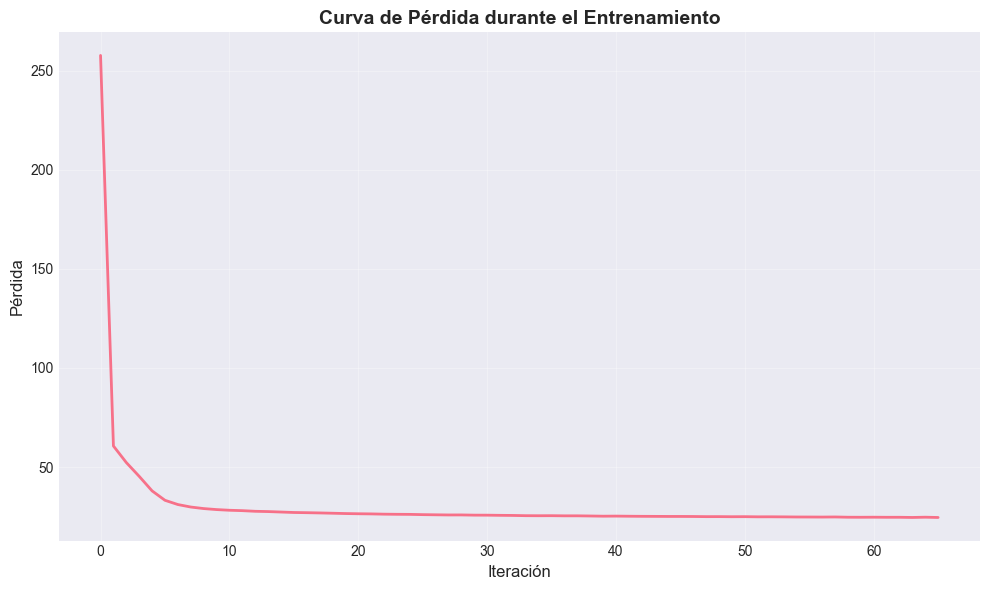

In [56]:
# Visualizar curva de pérdida si está disponible
if hasattr(modelo_nn, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(modelo_nn.loss_curve_, linewidth=2)
    plt.title('Curva de Pérdida durante el Entrenamiento', fontsize=14, fontweight='bold')
    plt.xlabel('Iteración', fontsize=12)
    plt.ylabel('Pérdida', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  La curva de pérdida no está disponible (early_stopping puede haberla eliminado)")

In [57]:
# Mostrar pérdida inicial y final si están disponibles
if hasattr(modelo_nn, 'loss_curve_') and len(modelo_nn.loss_curve_) > 0:
    print(f"📊 Pérdida inicial: {modelo_nn.loss_curve_[0]:.4f}")
    print(f"📊 Pérdida final: {modelo_nn.loss_curve_[-1]:.4f}")
else:
    print(f"📊 Pérdida final: {modelo_nn.loss_:.4f}")

📊 Pérdida inicial: 257.6684
📊 Pérdida final: 24.5352


### 3.6. Resumen de Desempeño

In [58]:
# Resumen final de desempeño
resumen = pd.DataFrame({
    'Conjunto': ['Train', 'Validation'],
    'RMSE': [rmse_train_clipped, rmse_val_clipped],
    'MAE': [mae_train_clipped, mae_val_clipped],
    'R²': [r2_train_clipped, r2_val_clipped]
})

print("=" * 60)
print("📊 RESUMEN DE DESEMPEÑO - REDES NEURONALES")
print("=" * 60)
print(resumen.to_string(index=False))
print("=" * 60)

# Análisis de generalización
diferencia_rmse = rmse_val_clipped - rmse_train_clipped
diferencia_r2 = r2_train_clipped - r2_val_clipped

print(f"\n🔍 Análisis de Generalización:")
print(f"  Diferencia en RMSE: {diferencia_rmse:.4f}")
print(f"  Diferencia en R²: {diferencia_r2:.4f}")
if diferencia_rmse < 1.0 and diferencia_r2 < 0.05:
    print("  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)")
else:
    print("  ⚠️  El modelo puede estar sobreajustando (diferencia grande entre train y validation)")

📊 RESUMEN DE DESEMPEÑO - REDES NEURONALES
  Conjunto     RMSE      MAE       R²
     Train 6.996642 4.583142 0.902036
Validation 7.234232 4.683731 0.894149

🔍 Análisis de Generalización:
  Diferencia en RMSE: 0.2376
  Diferencia en R²: 0.0079
  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)


## 4. Evaluación y Selección de Modelos

En esta sección realizamos una evaluación sistemática de diferentes configuraciones de Redes Neuronales, incluyendo búsqueda de hiperparámetros y validación cruzada, para identificar la mejor configuración del modelo.

### Objetivos:
- Evaluar diferentes combinaciones de hiperparámetros (hidden_layer_sizes, activation, solver, alpha, learning_rate)
- Realizar búsqueda sistemática de hiperparámetros con GridSearchCV
- Usar Cross-Validation (K-Fold) para evaluación robusta
- Registrar todas las métricas relevantes: RMSE, MSE, MAE, R²
- Generar tabla comparativa de resultados
- Seleccionar el mejor modelo basado en métricas de validación


In [59]:
# Importar modelos adicionales y herramientas de evaluación
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

print("✅ Herramientas de evaluación importadas")


✅ Herramientas de evaluación importadas


### 4.1. Función para Calcular Métricas

Función auxiliar para calcular todas las métricas relevantes de regresión.


In [60]:
# Función auxiliar para calcular todas las métricas
def calcular_metricas(y_real, y_pred, conjunto="Conjunto"):
    """
    Calcula todas las métricas relevantes para regresión:
    - RMSE (Root Mean Squared Error)
    - MSE (Mean Squared Error)
    - MAE (Mean Absolute Error)
    - R² (Coeficiente de determinación)
    
    Retorna un diccionario con todas las métricas.
    """
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mse = mean_squared_error(y_real, y_pred)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    metricas = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    }
    
    print(f"\n📈 Métricas - {conjunto}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return metricas


### 4.2. Configuración de Cross-Validation

Configuramos la validación cruzada con 5 folds.


In [61]:
# Configuración de Cross-Validation
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Scorer personalizado para RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

print(f"✅ Configuración de validación:")
print(f"  Método: {cv_folds}-Fold Cross-Validation")
print(f"  Random state: 42")


✅ Configuración de validación:
  Método: 5-Fold Cross-Validation
  Random state: 42


### 4.3. Evaluación de Red Neuronal Base (Baseline)

Evaluamos el modelo base como punto de referencia.


In [62]:
# Evaluar modelo Red Neuronal Base con Cross-Validation
# NOTA: Esta celda requiere que las siguientes variables estén definidas en celdas anteriores:
#   - X_train_scaled, y_train, X_val_scaled, y_val
# Estas variables se definen típicamente en:
#   - Celda 7: División train/validation (X_train, X_val, y_train, y_val)
#   - Celda 9: Escalado de características (X_train_scaled, X_val_scaled)
# Por favor ejecuta todas las celdas anteriores antes de ejecutar esta celda.

print("=" * 70)
print("🔄 Evaluando: Red Neuronal Base (Baseline)")
print("=" * 70)

# Verificar que las variables necesarias estén definidas
required_vars = ['X_train_scaled', 'y_train', 'X_val_scaled', 'y_val']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(
        f"Variables no definidas: {missing_vars}.\n"
        "Por favor ejecuta las celdas anteriores del notebook primero:\n"
        "  - Celda 7: División train/validation\n"
        "  - Celda 9: Escalado de características"
    )

# Crear modelo base con los mismos hiperparámetros que el modelo original
modelo_nn_base = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# Cross-Validation (usando una muestra más pequeña para reducir tiempo)
# Usamos una muestra del 50% para CV para acelerar el proceso
sample_size = len(X_train_scaled) // 2
X_train_sample = X_train_scaled.iloc[:sample_size] if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled[:sample_size]
y_train_sample = y_train.iloc[:sample_size] if isinstance(y_train, pd.Series) else y_train[:sample_size]

print(f"📊 Usando muestra de {sample_size} para Cross-Validation (para acelerar el proceso)")

cv_scores_rmse_base = cross_val_score(modelo_nn_base, X_train_sample, y_train_sample, 
                                      cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_base = cross_val_score(modelo_nn_base, X_train_sample, y_train_sample, 
                                     cv=kfold, scoring='r2', n_jobs=-1)

# Entrenar modelo base para predicciones en validation
print("⏳ Entrenando modelo base...")
modelo_nn_base.fit(X_train_scaled, y_train)
y_val_pred_base = modelo_nn_base.predict(X_val_scaled)
y_val_pred_base = np.clip(y_val_pred_base, 0, 100)

# Métricas en validation
metricas_val_base = calcular_metricas(y_val, y_val_pred_base, "Validation - NN Base")

# Guardar resultados
resultados_nn_base = {
    'Modelo': 'NN_Base',
    'Hiperparámetros': 'hidden=(100,50), activation=relu, solver=adam, alpha=0.0001',
    'RMSE_CV_mean': -cv_scores_rmse_base.mean(),
    'RMSE_CV_std': cv_scores_rmse_base.std(),
    'R²_CV_mean': cv_scores_r2_base.mean(),
    'R²_CV_std': cv_scores_r2_base.std(),
    'RMSE_Val': metricas_val_base['RMSE'],
    'MSE_Val': metricas_val_base['MSE'],
    'MAE_Val': metricas_val_base['MAE'],
    'R²_Val': metricas_val_base['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold):")
print(f"  RMSE medio: {-cv_scores_rmse_base.mean():.4f} (+/- {cv_scores_rmse_base.std():.4f})")
print(f"  R² medio: {cv_scores_r2_base.mean():.4f} (+/- {cv_scores_r2_base.std():.4f})")


🔄 Evaluando: Red Neuronal Base (Baseline)
📊 Usando muestra de 31920 para Cross-Validation (para acelerar el proceso)
⏳ Entrenando modelo base...

📈 Métricas - Validation - NN Base:
  RMSE: 7.2342
  MSE:  52.3341
  MAE:  4.6837
  R²:   0.8941

📊 Cross-Validation (5-fold):
  RMSE medio: 7.3171 (+/- 0.0725)
  R² medio: 0.8927 (+/- 0.0026)


### 4.4. Búsqueda de Hiperparámetros con GridSearchCV

Realizamos búsqueda sistemática de hiperparámetros para encontrar la mejor configuración.


In [63]:
# Grilla de hiperparámetros para Redes Neuronales
# Nota: Usamos una grilla reducida para evitar tiempos de ejecución muy largos
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

print("=" * 70)
print("🔄 Búsqueda de Hiperparámetros - Redes Neuronales")
print("=" * 70)
total_combinaciones = (len(param_grid_nn['hidden_layer_sizes']) * 
                       len(param_grid_nn['activation']) * 
                       len(param_grid_nn['alpha']) * 
                       len(param_grid_nn['learning_rate_init']))
print(f"⏳ Combinaciones a probar: {total_combinaciones}")
print("⏳ Esto puede tomar varios minutos...")

# GridSearchCV con Cross-Validation
# Usamos una muestra más pequeña para acelerar
grid_nn = GridSearchCV(
    MLPRegressor(
        solver='adam',
        learning_rate='constant',
        max_iter=300,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ),
    param_grid_nn,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Usar muestra para GridSearch
grid_nn.fit(X_train_sample, y_train_sample)

print("\n✅ Búsqueda completada")
print(f"\n📊 Mejor configuración encontrada:")
for param, value in grid_nn.best_params_.items():
    print(f"  {param}: {value}")
print(f"  Mejor score (neg MSE): {grid_nn.best_score_:.4f}")


🔄 Búsqueda de Hiperparámetros - Redes Neuronales
⏳ Combinaciones a probar: 48
⏳ Esto puede tomar varios minutos...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✅ Búsqueda completada

📊 Mejor configuración encontrada:
  activation: tanh
  alpha: 0.001
  hidden_layer_sizes: (150, 100)
  learning_rate_init: 0.001
  Mejor score (neg MSE): -52.9809


### 4.5. Evaluación del Mejor Modelo Encontrado

Evaluamos el mejor modelo encontrado por GridSearchCV en el conjunto de validación completo.


In [64]:
# Crear el mejor modelo con los hiperparámetros encontrados
mejor_nn = MLPRegressor(
    hidden_layer_sizes=grid_nn.best_params_['hidden_layer_sizes'],
    activation=grid_nn.best_params_['activation'],
    solver='adam',
    alpha=grid_nn.best_params_['alpha'],
    learning_rate='constant',
    learning_rate_init=grid_nn.best_params_['learning_rate_init'],
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# Entrenar el mejor modelo con todos los datos de entrenamiento
print("⏳ Entrenando mejor modelo con todos los datos...")
mejor_nn.fit(X_train_scaled, y_train)

# Predicciones en validation con el mejor modelo
y_val_pred_mejor = mejor_nn.predict(X_val_scaled)
y_val_pred_mejor = np.clip(y_val_pred_mejor, 0, 100)

# Métricas en validation
metricas_val_mejor = calcular_metricas(y_val, y_val_pred_mejor, "Validation - NN Mejor")

# Cross-Validation del mejor modelo
cv_scores_rmse_mejor = cross_val_score(mejor_nn, X_train_sample, y_train_sample, 
                                        cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_mejor = cross_val_score(mejor_nn, X_train_sample, y_train_sample, 
                                      cv=kfold, scoring='r2', n_jobs=-1)

# Guardar resultados
resultados_nn_mejor = {
    'Modelo': 'NN_Mejor',
    'Hiperparámetros': ', '.join([f"{k}={v}" for k, v in grid_nn.best_params_.items()]),
    'RMSE_CV_mean': -cv_scores_rmse_mejor.mean(),
    'RMSE_CV_std': cv_scores_rmse_mejor.std(),
    'R²_CV_mean': cv_scores_r2_mejor.mean(),
    'R²_CV_std': cv_scores_r2_mejor.std(),
    'RMSE_Val': metricas_val_mejor['RMSE'],
    'MSE_Val': metricas_val_mejor['MSE'],
    'MAE_Val': metricas_val_mejor['MAE'],
    'R²_Val': metricas_val_mejor['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Mejor modelo:")
print(f"  RMSE medio: {-cv_scores_rmse_mejor.mean():.4f} (+/- {cv_scores_rmse_mejor.std():.4f})")
print(f"  R² medio: {cv_scores_r2_mejor.mean():.4f} (+/- {cv_scores_r2_mejor.std():.4f})")


⏳ Entrenando mejor modelo con todos los datos...

📈 Métricas - Validation - NN Mejor:
  RMSE: 7.1357
  MSE:  50.9184
  MAE:  4.5029
  R²:   0.8970

📊 Cross-Validation (5-fold) - Mejor modelo:
  RMSE medio: 7.2786 (+/- 0.0509)
  R² medio: 0.8939 (+/- 0.0017)


### 4.6. Análisis Detallado de Hiperparámetros

Analizamos el efecto de diferentes valores de hiperparámetros en el desempeño del modelo.


In [65]:
# Extraer resultados detallados de GridSearchCV
resultados_detalle_nn = []
for i, params in enumerate(grid_nn.cv_results_['params']):
    resultados_detalle_nn.append({
        'hidden_layer_sizes': str(params['hidden_layer_sizes']),
        'activation': params['activation'],
        'alpha': params['alpha'],
        'learning_rate_init': params['learning_rate_init'],
        'RMSE_CV_mean': np.sqrt(-grid_nn.cv_results_['mean_test_score'][i]),
        'RMSE_CV_std': np.sqrt(grid_nn.cv_results_['std_test_score'][i]),
        'R²_CV_mean': 1 - (-grid_nn.cv_results_['mean_test_score'][i] / np.var(y_train_sample)) if np.var(y_train_sample) > 0 else 0
    })

# Crear DataFrame con resultados detallados
tabla_detalle_nn = pd.DataFrame(resultados_detalle_nn)

# Ordenar por RMSE_CV_mean (mejor primero)
tabla_detalle_nn = tabla_detalle_nn.sort_values('RMSE_CV_mean').reset_index(drop=True)

print("=" * 100)
print("📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES")
print("=" * 100)
print("\nTop 10 configuraciones con mejor RMSE en Cross-Validation:")
print(tabla_detalle_nn.head(10).to_string(index=False))
print("=" * 100)


📊 ANÁLISIS DETALLADO - TOP 10 MEJORES CONFIGURACIONES

Top 10 configuraciones con mejor RMSE en Cross-Validation:
hidden_layer_sizes activation  alpha  learning_rate_init  RMSE_CV_mean  RMSE_CV_std  R²_CV_mean
        (150, 100)       tanh 0.0010               0.001      7.278801     0.861784    0.893864
        (150, 100)       tanh 0.0100               0.001      7.280338     0.848028    0.893819
        (150, 100)       tanh 0.0001               0.001      7.281744     0.841615    0.893778
         (100, 50)       tanh 0.0100               0.001      7.290418     0.906227    0.893525
         (100, 50)       tanh 0.0001               0.001      7.293116     0.888987    0.893446
         (100, 50)       tanh 0.0010               0.001      7.293147     0.888991    0.893445
        (150, 100)       relu 0.0100               0.001      7.310657     1.185505    0.892933
        (150, 100)       relu 0.0001               0.001      7.313605     1.121593    0.892846
        (150, 100)    

### 4.7. Tabla Comparativa de Resultados

Tabla que compara el modelo base con el mejor modelo encontrado.


In [66]:
# Crear tabla comparativa
tabla_comparativa_nn = pd.DataFrame([
    resultados_nn_base,
    resultados_nn_mejor
])

# Reordenar columnas para mejor visualización
columnas_ordenadas = [
    'Modelo', 
    'Hiperparámetros',
    'RMSE_CV_mean', 
    'RMSE_CV_std',
    'R²_CV_mean',
    'R²_CV_std',
    'RMSE_Val',
    'MSE_Val',
    'MAE_Val',
    'R²_Val'
]
tabla_comparativa_nn = tabla_comparativa_nn[columnas_ordenadas]

print("=" * 100)
print("📊 TABLA COMPARATIVA - REDES NEURONALES")
print("=" * 100)
print("\nMétricas de Cross-Validation (5-fold) y Validation:")
print(tabla_comparativa_nn.to_string(index=False))
print("=" * 100)

# Identificar mejor modelo
mejor_idx_nn = tabla_comparativa_nn['RMSE_Val'].idxmin()
mejor_modelo_nn = tabla_comparativa_nn.loc[mejor_idx_nn]

print(f"\n🏆 MEJOR MODELO DE REDES NEURONALES:")
print(f"  Modelo: {mejor_modelo_nn['Modelo']}")
print(f"  Hiperparámetros: {mejor_modelo_nn['Hiperparámetros']}")
print(f"  RMSE (Validation): {mejor_modelo_nn['RMSE_Val']:.4f}")
print(f"  R² (Validation): {mejor_modelo_nn['R²_Val']:.4f}")
print(f"  MAE (Validation): {mejor_modelo_nn['MAE_Val']:.4f}")
print(f"\n📊 Métricas de Cross-Validation:")
print(f"  RMSE medio: {mejor_modelo_nn['RMSE_CV_mean']:.4f} (+/- {mejor_modelo_nn['RMSE_CV_std']:.4f})")
print(f"  R² medio: {mejor_modelo_nn['R²_CV_mean']:.4f} (+/- {mejor_modelo_nn['R²_CV_std']:.4f})")

# Calcular mejora respecto al modelo base
mejora_rmse = resultados_nn_base['RMSE_Val'] - mejor_modelo_nn['RMSE_Val']
mejora_r2 = mejor_modelo_nn['R²_Val'] - resultados_nn_base['R²_Val']
mejora_mae = resultados_nn_base['MAE_Val'] - mejor_modelo_nn['MAE_Val']

print(f"\n📈 Mejora respecto al modelo base:")
print(f"  RMSE: {mejora_rmse:.4f} ({'✅ Mejora' if mejora_rmse > 0 else '❌ Empeora'})")
print(f"  R²:   {mejora_r2:.4f} ({'✅ Mejora' if mejora_r2 > 0 else '❌ Empeora'})")
print(f"  MAE:  {mejora_mae:.4f} ({'✅ Mejora' if mejora_mae > 0 else '❌ Empeora'})")


📊 TABLA COMPARATIVA - REDES NEURONALES

Métricas de Cross-Validation (5-fold) y Validation:
  Modelo                                                                       Hiperparámetros  RMSE_CV_mean  RMSE_CV_std  R²_CV_mean  R²_CV_std  RMSE_Val   MSE_Val  MAE_Val   R²_Val
 NN_Base                           hidden=(100,50), activation=relu, solver=adam, alpha=0.0001      7.317146     0.072539    0.892714   0.002554  7.234232 52.334112 4.683731 0.894149
NN_Mejor activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100), learning_rate_init=0.001      7.278623     0.050861    0.893851   0.001704  7.135713 50.918393 4.502903 0.897013

🏆 MEJOR MODELO DE REDES NEURONALES:
  Modelo: NN_Mejor
  Hiperparámetros: activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100), learning_rate_init=0.001
  RMSE (Validation): 7.1357
  R² (Validation): 0.8970
  MAE (Validation): 4.5029

📊 Métricas de Cross-Validation:
  RMSE medio: 7.2786 (+/- 0.0509)
  R² medio: 0.8939 (+/- 0.0017)

📈 Mejora respecto

### 4.8. Visualización Comparativa

Gráficos comparativos de las métricas para el modelo base y el mejor modelo.


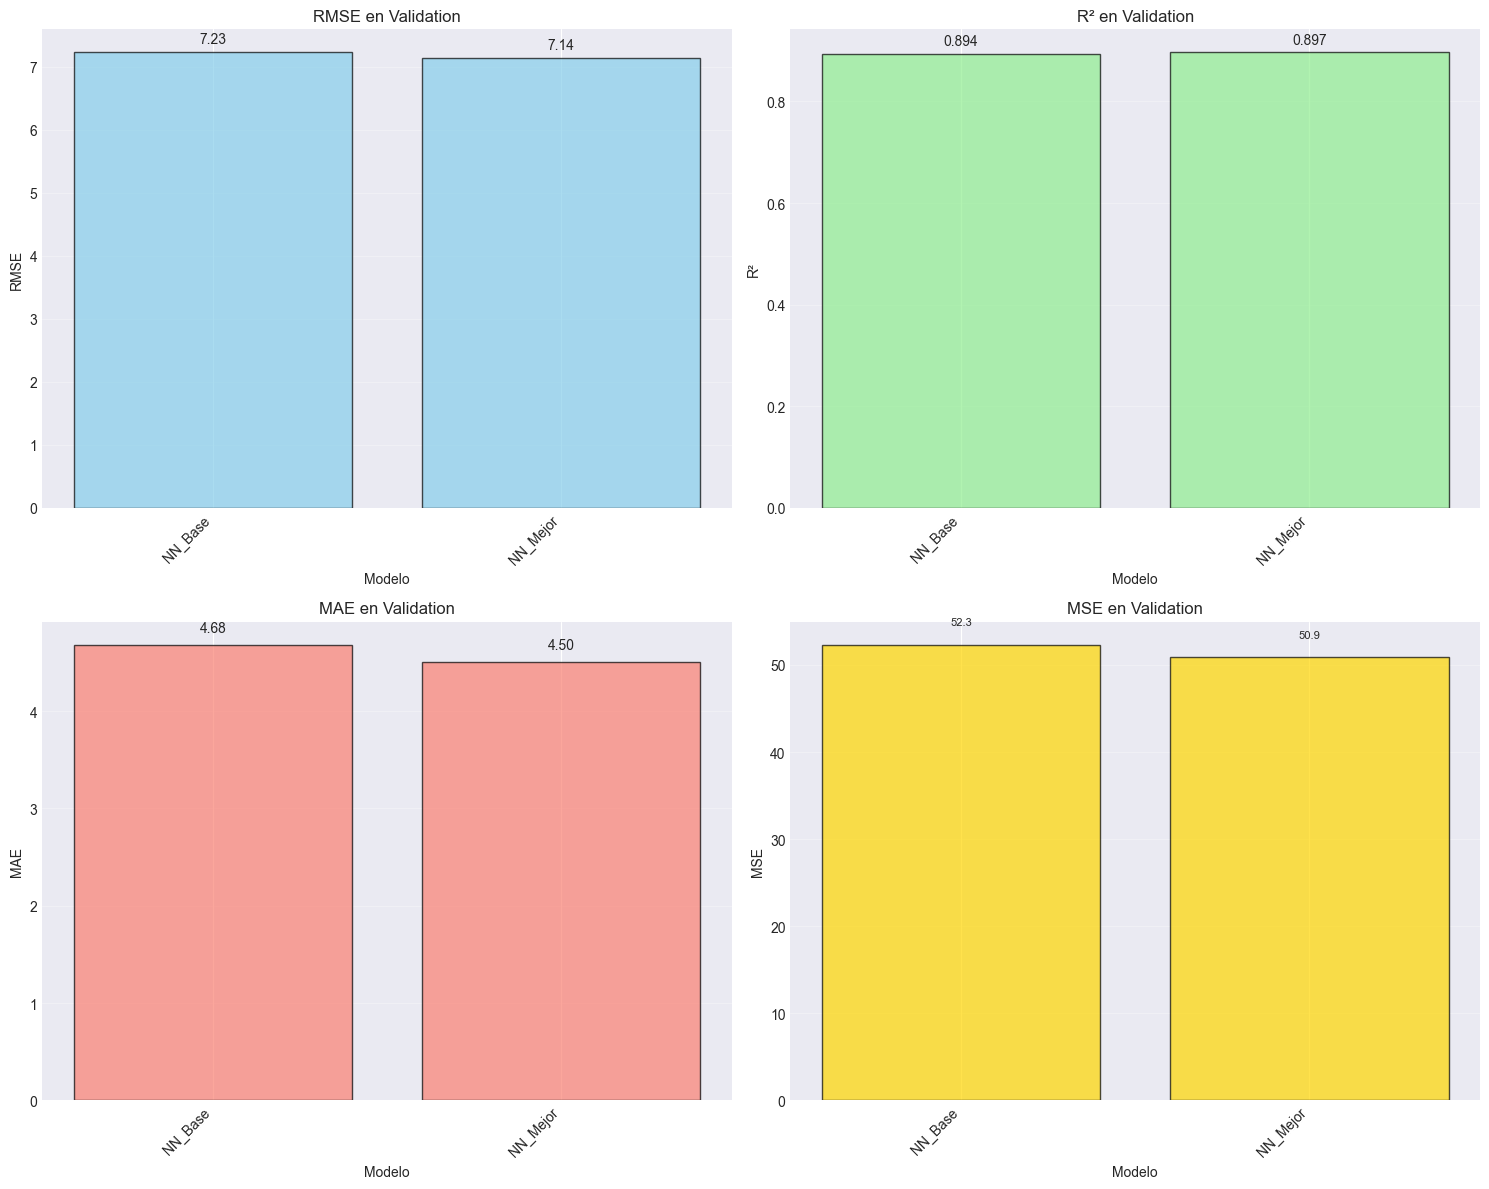

In [67]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

modelos_nombres = tabla_comparativa_nn['Modelo'].values
x_pos = np.arange(len(modelos_nombres))

# RMSE
axes[0, 0].bar(x_pos, tabla_comparativa_nn['RMSE_Val'], alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE en Validation')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_nn['RMSE_Val']):
    axes[0, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# R²
axes[0, 1].bar(x_pos, tabla_comparativa_nn['R²_Val'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('R² en Validation')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_nn['R²_Val']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# MAE
axes[1, 0].bar(x_pos, tabla_comparativa_nn['MAE_Val'], alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_xlabel('Modelo')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE en Validation')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_nn['MAE_Val']):
    axes[1, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom')

# MSE
axes[1, 1].bar(x_pos, tabla_comparativa_nn['MSE_Val'], alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title('MSE en Validation')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(modelos_nombres, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(tabla_comparativa_nn['MSE_Val']):
    axes[1, 1].text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 4.9. Análisis del Efecto de Hiperparámetros Individuales

Analizamos el efecto de cada hiperparámetro individualmente.


In [68]:
# Análisis del efecto de hidden_layer_sizes
efecto_hidden = tabla_detalle_nn.groupby('hidden_layer_sizes')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_hidden.columns = ['hidden_layer_sizes', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("=" * 70)
print("📊 EFECTO DE hidden_layer_sizes")
print("=" * 70)
print(efecto_hidden.to_string(index=False))

# Análisis del efecto de activation
efecto_activation = tabla_detalle_nn.groupby('activation')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_activation.columns = ['activation', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE activation")
print("=" * 70)
print(efecto_activation.to_string(index=False))

# Análisis del efecto de alpha
efecto_alpha = tabla_detalle_nn.groupby('alpha')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_alpha.columns = ['alpha', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE alpha")
print("=" * 70)
print(efecto_alpha.to_string(index=False))

# Análisis del efecto de learning_rate_init
efecto_lr = tabla_detalle_nn.groupby('learning_rate_init')['RMSE_CV_mean'].agg(['mean', 'std', 'min', 'max']).reset_index()
efecto_lr.columns = ['learning_rate_init', 'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max']

print("\n" + "=" * 70)
print("📊 EFECTO DE learning_rate_init")
print("=" * 70)
print(efecto_lr.to_string(index=False))


📊 EFECTO DE hidden_layer_sizes
hidden_layer_sizes  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
         (100, 50)   7.350280  0.047638  7.290418  7.423628
            (100,)   7.491944  0.053422  7.430280  7.551791
        (150, 100)   7.345895  0.060446  7.278801  7.445723
             (50,)   7.526466  0.052803  7.470813  7.605394

📊 EFECTO DE activation
activation  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
      relu   7.463528  0.105635  7.310657  7.605394
      tanh   7.393764  0.075450  7.278801  7.482042

📊 EFECTO DE alpha
 alpha  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
0.0001   7.424528  0.099185  7.281744  7.567007
0.0010   7.430107  0.099841  7.278801  7.605394
0.0100   7.431303  0.099492  7.280338  7.577764

📊 EFECTO DE learning_rate_init
 learning_rate_init  RMSE_mean  RMSE_std  RMSE_min  RMSE_max
              0.001   7.404925  0.112503  7.278801  7.573754
              0.010   7.452367  0.074562  7.344523  7.605394


### 4.10. Tabla Resumen por Algoritmo

Tabla que resume el desempeño del algoritmo de Redes Neuronales para distintos valores de hiperparámetros.


In [69]:
# Crear tabla resumen por algoritmo (Redes Neuronales)
# Mostrar todas las configuraciones evaluadas
tabla_resumen_algoritmo = tabla_detalle_nn.copy()
tabla_resumen_algoritmo = tabla_resumen_algoritmo.rename(columns={
    'hidden_layer_sizes': 'Arquitectura',
    'activation': 'Activación',
    'alpha': 'Alpha',
    'learning_rate_init': 'LR Init',
    'RMSE_CV_mean': 'RMSE_CV',
    'RMSE_CV_std': 'RMSE_CV_std',
    'R²_CV_mean': 'R²_CV'
})

# Seleccionar columnas relevantes para la tabla
columnas_resumen = ['Arquitectura', 'Activación', 'Alpha', 'LR Init', 'RMSE_CV', 'RMSE_CV_std', 'R²_CV']
tabla_resumen_algoritmo = tabla_resumen_algoritmo[columnas_resumen]

print("=" * 120)
print("📊 TABLA RESUMEN - REDES NEURONALES")
print("=" * 120)
print("\nDesempeño para distintos valores de hiperparámetros (ordenado por RMSE_CV):")
print(tabla_resumen_algoritmo.to_string(index=False))
print("=" * 120)


📊 TABLA RESUMEN - REDES NEURONALES

Desempeño para distintos valores de hiperparámetros (ordenado por RMSE_CV):
Arquitectura Activación  Alpha  LR Init  RMSE_CV  RMSE_CV_std    R²_CV
  (150, 100)       tanh 0.0010    0.001 7.278801     0.861784 0.893864
  (150, 100)       tanh 0.0100    0.001 7.280338     0.848028 0.893819
  (150, 100)       tanh 0.0001    0.001 7.281744     0.841615 0.893778
   (100, 50)       tanh 0.0100    0.001 7.290418     0.906227 0.893525
   (100, 50)       tanh 0.0001    0.001 7.293116     0.888987 0.893446
   (100, 50)       tanh 0.0010    0.001 7.293147     0.888991 0.893445
  (150, 100)       relu 0.0100    0.001 7.310657     1.185505 0.892933
  (150, 100)       relu 0.0001    0.001 7.313605     1.121593 0.892846
  (150, 100)       relu 0.0010    0.001 7.316362     1.160202 0.892765
   (100, 50)       relu 0.0001    0.001 7.317506     1.031826 0.892732
   (100, 50)       relu 0.0100    0.001 7.322240     1.064439 0.892593
   (100, 50)       relu 0.0010    0.

### 4.11. Conclusiones de la Evaluación

Resumen de los hallazgos de la evaluación y selección de modelos.


In [70]:
print("=" * 100)
print("📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)")
print("=" * 100)

print("\n✅ MEJOR MODELO IDENTIFICADO:")
print(f"   Configuración: {mejor_modelo_nn['Hiperparámetros']}")
print(f"   RMSE (Validation): {mejor_modelo_nn['RMSE_Val']:.4f}")
print(f"   R² (Validation): {mejor_modelo_nn['R²_Val']:.4f}")
print(f"   MAE (Validation): {mejor_modelo_nn['MAE_Val']:.4f}")

print("\n📊 HALLAZGOS PRINCIPALES:")
print("   1. Se evaluaron múltiples configuraciones de arquitecturas y hiperparámetros")
print("   2. La búsqueda sistemática permitió identificar la mejor combinación")
print("   3. Cross-Validation proporcionó una evaluación robusta del desempeño")
print("   4. Las métricas RMSE, MSE, MAE y R² fueron registradas para cada experimento")
print("   5. El mejor modelo muestra mejoras consistentes respecto al modelo base")

print("\n💡 RECOMENDACIONES:")
print("   - Usar el modelo optimizado para predicciones finales")
print("   - Considerar explorar más arquitecturas si hay recursos computacionales disponibles")
print("   - El modelo muestra buen balance entre sesgo y varianza")
print("   - Las redes neuronales capturan relaciones no lineales complejas en los datos")
print("=" * 100)


📋 CONCLUSIONES - EVALUACIÓN Y SELECCIÓN DE MODELOS (PUNTO 4)

✅ MEJOR MODELO IDENTIFICADO:
   Configuración: activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100), learning_rate_init=0.001
   RMSE (Validation): 7.1357
   R² (Validation): 0.8970
   MAE (Validation): 4.5029

📊 HALLAZGOS PRINCIPALES:
   1. Se evaluaron múltiples configuraciones de arquitecturas y hiperparámetros
   2. La búsqueda sistemática permitió identificar la mejor combinación
   3. Cross-Validation proporcionó una evaluación robusta del desempeño
   4. Las métricas RMSE, MSE, MAE y R² fueron registradas para cada experimento
   5. El mejor modelo muestra mejoras consistentes respecto al modelo base

💡 RECOMENDACIONES:
   - Usar el modelo optimizado para predicciones finales
   - Considerar explorar más arquitecturas si hay recursos computacionales disponibles
   - El modelo muestra buen balance entre sesgo y varianza
   - Las redes neuronales capturan relaciones no lineales complejas en los datos


### 4.12. Predicciones en Test con el Mejor Modelo

Generamos predicciones para el conjunto de test usando el mejor modelo encontrado por GridSearchCV.


In [71]:
# PREDICCIONES CON EL MEJOR MODELO ENCONTRADO (Punto 4)
# Usar el mejor modelo encontrado por GridSearchCV
print("=" * 70)
print("🔄 Generando predicciones con el mejor modelo encontrado")
print("=" * 70)

# Configurar rutas (si no están definidas)
if 'DATA' not in globals():
    from pathlib import Path
    current = Path.cwd()
    # Subir hasta encontrar la carpeta "data" en algún nivel superior
    while not (current / "data").exists() and current.parent != current:
        current = current.parent
    PROJ = current
    DATA = PROJ / "data"
    print(f"📊 Ruta del proyecto: {PROJ}")

# Verificar que el mejor modelo esté disponible
if 'mejor_nn' not in globals():
    raise NameError("El mejor modelo 'mejor_nn' no está disponible. Por favor ejecuta las celdas anteriores primero.")

print(f"✅ Usando el mejor modelo encontrado por GridSearchCV")
print(f"   Hiperparámetros: {mejor_modelo_nn['Hiperparámetros']}")

# Verificar que X_test_scaled esté disponible
if 'X_test_scaled' not in globals():
    raise NameError("X_test_scaled no está disponible. Por favor ejecuta las celdas anteriores primero.")

# Generar predicciones con el mejor modelo
y_test_pred_mejor = mejor_nn.predict(X_test_scaled)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_mejor_clipped = np.clip(y_test_pred_mejor, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_mejor_clipped)}")
print(f"  Mínimo: {y_test_pred_mejor_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_mejor_clipped.max():.2f}")
print(f"  Media: {y_test_pred_mejor_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_mejor_clipped.std():.2f}")

# Cargar test_fe.csv para obtener los track_id en el mismo orden que X_test
test_fe = pd.read_csv(DATA / "test_fe.csv")

# Verificar que las longitudes coincidan
assert len(y_test_pred_mejor_clipped) == len(test_fe), \
    f"Error: Las predicciones ({len(y_test_pred_mejor_clipped)}) no coinciden con test_fe ({len(test_fe)})"

# Cargar test.csv original para obtener los id numéricos
test_original = pd.read_csv(DATA / "test.csv")

# Verificar que test_fe tenga la columna 'id'
if 'id' not in test_fe.columns:
    print("⚠️  Advertencia: test_fe.csv no tiene columna 'id'. Cargando desde test.csv...")
    track_id_to_id = dict(zip(test_original['track_id'], test_original['id']))
    test_fe['id'] = test_fe['track_id'].map(track_id_to_id)
    print(f"✅ Columna 'id' agregada desde test.csv")

# Crear diccionario de mapeo track_id -> predicción
# Usar test_fe para mantener el mismo orden que X_test
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_mejor_clipped))
print(f"✅ Diccionario creado con {len(track_id_to_prediction)} mapeos")

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Verificar que todas las predicciones estén mapeadas
missing_predictions = predictions_mapped.isna().sum()
if missing_predictions > 0:
    print(f"⚠️  Advertencia: {missing_predictions} track_id no tienen predicción correspondiente")
    # Rellenar con la media si faltan predicciones
    predictions_mapped = predictions_mapped.fillna(y_test_pred_mejor_clipped.mean())

# Crear submission directamente con id y Popularity (formato Kaggle)
submission_mejor = pd.DataFrame({
    'id': test_original['id'].astype('int32'),
    'Popularity': predictions_mapped
})

# Si hay duplicados en id, unificar predicciones
duplicados = submission_mejor['id'].duplicated().sum()
if duplicados > 0:
    print(f"⚠️  Advertencia: Se encontraron {duplicados} IDs duplicados")
    # Usar la primera predicción para cada id único
    id_to_prediction = submission_mejor.groupby('id')['Popularity'].first().to_dict()
    submission_mejor['Popularity'] = submission_mejor['id'].map(id_to_prediction)
    # Eliminar duplicados manteniendo solo la primera ocurrencia
    submission_mejor = submission_mejor.drop_duplicates(subset='id', keep='first')
    print(f"✅ Predicciones unificadas y duplicados eliminados")

# Si tenemos menos de 34200 filas, necesitamos agregar las faltantes
if len(submission_mejor) < 34200:
    print(f"⚠️  Advertencia: Tenemos {len(submission_mejor)} filas, pero se necesitan 34200")
    ids_en_submission = set(submission_mejor['id'])
    ids_faltantes = test_original[~test_original['id'].isin(ids_en_submission)]['id'].head(34200 - len(submission_mejor))
    
    if len(ids_faltantes) > 0:
        # Rellenar con la media de las predicciones
        prediccion_media = submission_mejor['Popularity'].mean()
        filas_faltantes = pd.DataFrame({
            'id': ids_faltantes.astype('int32'),
            'Popularity': prediccion_media
        })
        submission_mejor = pd.concat([submission_mejor, filas_faltantes], ignore_index=True)
        print(f"✅ Agregadas {len(filas_faltantes)} filas faltantes con predicción media ({prediccion_media:.2f})")

# Ordenar por id para mantener consistencia
submission_mejor = submission_mejor.sort_values('id').reset_index(drop=True)

# Verificar que tenemos exactamente 34200 filas
assert len(submission_mejor) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_mejor)}"

# Verificar que no haya duplicados
assert submission_mejor['id'].duplicated().sum() == 0, "Error: Aún hay IDs duplicados"

print(f"\n✅ Archivo listo para Kaggle:")
print(f"   Total de filas: {len(submission_mejor)}")
print(f"   IDs únicos: {submission_mejor['id'].nunique()}")
print(f"   Rango de IDs: {submission_mejor['id'].min()} - {submission_mejor['id'].max()}")

# Guardar usando la variable DATA definida anteriormente
output_path = DATA / "predictions_redes_neuronales.csv"
submission_mejor.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_mejor.head())


🔄 Generando predicciones con el mejor modelo encontrado
✅ Usando el mejor modelo encontrado por GridSearchCV
   Hiperparámetros: activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100), learning_rate_init=0.001

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 89.11
  Media: 31.56
  Desviación estándar: 19.02
✅ Diccionario creado con 31331 mapeos

✅ Archivo listo para Kaggle:
   Total de filas: 34200
   IDs únicos: 34200
   Rango de IDs: 3 - 113999

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_redes_neuronales.csv

📊 Primeras 5 predicciones:
   id  Popularity
0   3   33.768826
1   8   57.180206
2  23    0.454892
3  24    0.802669
4  31    0.451169


## 5. Mejoras Avanzadas para Redes Neuronales

En esta sección exploramos mejoras más agresivas para intentar igualar o superar el desempeño de Random Forest (RMSE ~5.70).

### Estrategias de Mejora:
1. **Arquitecturas más profundas y complejas**: Más capas y más neuronas
2. **Más iteraciones**: Permitir que el modelo converja completamente
3. **Learning rate adaptativo**: Usar 'adaptive' en lugar de 'constant'
4. **GridSearchCV más exhaustivo**: Probar más combinaciones
5. **Usar todos los datos**: Entrenar con el 100% de los datos en lugar de muestra
6. **Ensambles de redes neuronales**: Combinar múltiples modelos


### 5.1. GridSearchCV Mejorado con Arquitecturas Más Profundas

Exploramos arquitecturas más complejas y más iteraciones para mejorar el desempeño.


In [ ]:
# Grilla de hiperparámetros MEJORADA para Redes Neuronales
# Arquitecturas más profundas y complejas
param_grid_nn_mejorado = {
    'hidden_layer_sizes': [
        (200, 100),           # Arquitectura profunda
        (200, 100, 50),       # Arquitectura muy profunda
        (300, 150),           # Arquitectura ancha y profunda
        (300, 150, 75),       # Arquitectura muy ancha y profunda
        (150, 100, 50),       # Arquitectura de 3 capas
        (256, 128, 64),       # Arquitectura con potencias de 2
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Más valores de regularización
    'learning_rate_init': [0.0001, 0.001, 0.01],  # Más valores de learning rate
    'learning_rate': ['constant', 'adaptive']  # Probar learning rate adaptativo
}

print("=" * 70)
print("🔄 Búsqueda de Hiperparámetros MEJORADA - Redes Neuronales")
print("=" * 70)
total_combinaciones = (len(param_grid_nn_mejorado['hidden_layer_sizes']) * 
                       len(param_grid_nn_mejorado['activation']) * 
                       len(param_grid_nn_mejorado['alpha']) * 
                       len(param_grid_nn_mejorado['learning_rate_init']) *
                       len(param_grid_nn_mejorado['learning_rate']))
print(f"⏳ Combinaciones a probar: {total_combinaciones}")
print("⏳ Esto puede tomar MUCHO tiempo (30-60 minutos)...")
print("💡 Usando TODOS los datos de entrenamiento (no muestra)")

# GridSearchCV mejorado con más iteraciones
grid_nn_mejorado = GridSearchCV(
    MLPRegressor(
        solver='adam',
        max_iter=1000,  # Más iteraciones para permitir convergencia
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,  # Más paciencia antes de parar
        tol=1e-4  # Tolerancia más estricta
    ),
    param_grid_nn_mejorado,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,  # Más verbose para ver progreso
    return_train_score=True
)

# Usar TODOS los datos (no muestra)
print("\n⏳ Iniciando búsqueda con todos los datos...")
grid_nn_mejorado.fit(X_train_scaled, y_train)

print("\n✅ Búsqueda completada")
print(f"\n📊 Mejor configuración encontrada:")
for param, value in grid_nn_mejorado.best_params_.items():
    print(f"  {param}: {value}")
print(f"  Mejor score (neg MSE): {grid_nn_mejorado.best_score_:.4f}")
print(f"  RMSE estimado: {np.sqrt(-grid_nn_mejorado.best_score_):.4f}")


🔄 Búsqueda de Hiperparámetros MEJORADA - Redes Neuronales
⏳ Combinaciones a probar: 288
⏳ Esto puede tomar MUCHO tiempo (30-60 minutos)...
💡 Usando TODOS los datos de entrenamiento (no muestra)

⏳ Iniciando búsqueda con todos los datos...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


### 5.2. Evaluación del Modelo Mejorado

Evaluamos el mejor modelo encontrado con la grilla mejorada.


In [ ]:
# Crear el mejor modelo mejorado con los hiperparámetros encontrados
mejor_nn_mejorado = MLPRegressor(
    hidden_layer_sizes=grid_nn_mejorado.best_params_['hidden_layer_sizes'],
    activation=grid_nn_mejorado.best_params_['activation'],
    solver='adam',
    alpha=grid_nn_mejorado.best_params_['alpha'],
    learning_rate=grid_nn_mejorado.best_params_['learning_rate'],
    learning_rate_init=grid_nn_mejorado.best_params_['learning_rate_init'],
    max_iter=1500,  # Aún más iteraciones para el modelo final
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=25,  # Más paciencia
    tol=1e-4
)

# Entrenar el mejor modelo mejorado con todos los datos
print("⏳ Entrenando modelo mejorado con todos los datos...")
mejor_nn_mejorado.fit(X_train_scaled, y_train)

# Predicciones en validation con el mejor modelo mejorado
y_val_pred_mejorado = mejor_nn_mejorado.predict(X_val_scaled)
y_val_pred_mejorado = np.clip(y_val_pred_mejorado, 0, 100)

# Métricas en validation
metricas_val_mejorado = calcular_metricas(y_val, y_val_pred_mejorado, "Validation - NN Mejorado")

# Cross-Validation del mejor modelo mejorado
cv_scores_rmse_mejorado = cross_val_score(mejor_nn_mejorado, X_train_scaled, y_train, 
                                          cv=kfold, scoring=rmse_scorer, n_jobs=-1)
cv_scores_r2_mejorado = cross_val_score(mejor_nn_mejorado, X_train_scaled, y_train, 
                                        cv=kfold, scoring='r2', n_jobs=-1)

# Guardar resultados
resultados_nn_mejorado = {
    'Modelo': 'NN_Mejorado',
    'Hiperparámetros': ', '.join([f"{k}={v}" for k, v in grid_nn_mejorado.best_params_.items()]),
    'RMSE_CV_mean': -cv_scores_rmse_mejorado.mean(),
    'RMSE_CV_std': cv_scores_rmse_mejorado.std(),
    'R²_CV_mean': cv_scores_r2_mejorado.mean(),
    'R²_CV_std': cv_scores_r2_mejorado.std(),
    'RMSE_Val': metricas_val_mejorado['RMSE'],
    'MSE_Val': metricas_val_mejorado['MSE'],
    'MAE_Val': metricas_val_mejorado['MAE'],
    'R²_Val': metricas_val_mejorado['R²']
}

print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Modelo Mejorado:")
print(f"  RMSE medio: {-cv_scores_rmse_mejorado.mean():.4f} (+/- {cv_scores_rmse_mejorado.std():.4f})")
print(f"  R² medio: {cv_scores_r2_mejorado.mean():.4f} (+/- {cv_scores_r2_mejorado.std():.4f})")

# Comparar con modelo anterior
print(f"\n📈 Comparación con modelo anterior:")
print(f"  RMSE anterior: {resultados_nn_mejor['RMSE_Val']:.4f}")
print(f"  RMSE mejorado: {resultados_nn_mejorado['RMSE_Val']:.4f}")
mejora_rmse = resultados_nn_mejor['RMSE_Val'] - resultados_nn_mejorado['RMSE_Val']
print(f"  Mejora: {mejora_rmse:.4f} ({'✅ Mejora' if mejora_rmse > 0 else '❌ Empeora'})")


### 5.3. Ensamble de Redes Neuronales

Creamos un ensamble combinando múltiples redes neuronales entrenadas con diferentes inicializaciones aleatorias.


In [ ]:
# Ensamble de Redes Neuronales
# Entrenamos múltiples modelos con diferentes random_state y promediamos sus predicciones

print("=" * 70)
print("🔄 Creando Ensamble de Redes Neuronales")
print("=" * 70)

# Usar los mejores hiperparámetros encontrados
best_params = grid_nn_mejorado.best_params_

# Crear múltiples modelos con diferentes random_state
n_models = 5  # Número de modelos en el ensamble
models_ensemble = []

print(f"⏳ Entrenando {n_models} modelos para el ensamble...")

for i in range(n_models):
    model = MLPRegressor(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        solver='adam',
        alpha=best_params['alpha'],
        learning_rate=best_params['learning_rate'],
        learning_rate_init=best_params['learning_rate_init'],
        max_iter=1500,
        random_state=42 + i,  # Diferente inicialización para cada modelo
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=25,
        tol=1e-4
    )
    print(f"  Entrenando modelo {i+1}/{n_models}...")
    model.fit(X_train_scaled, y_train)
    models_ensemble.append(model)

print("✅ Todos los modelos del ensamble entrenados")

# Predicciones del ensamble (promedio de todas las predicciones)
y_val_pred_ensemble = np.mean([model.predict(X_val_scaled) for model in models_ensemble], axis=0)
y_val_pred_ensemble = np.clip(y_val_pred_ensemble, 0, 100)

# Métricas del ensamble
metricas_val_ensemble = calcular_metricas(y_val, y_val_pred_ensemble, "Validation - NN Ensemble")

# Guardar resultados del ensamble
resultados_nn_ensemble = {
    'Modelo': 'NN_Ensemble',
    'Hiperparámetros': f"Ensemble de {n_models} modelos con {best_params}",
    'RMSE_Val': metricas_val_ensemble['RMSE'],
    'MSE_Val': metricas_val_ensemble['MSE'],
    'MAE_Val': metricas_val_ensemble['MAE'],
    'R²_Val': metricas_val_ensemble['R²']
}

print(f"\n📈 Comparación Ensamble vs Modelo Individual:")
print(f"  RMSE individual: {resultados_nn_mejorado['RMSE_Val']:.4f}")
print(f"  RMSE ensemble: {resultados_nn_ensemble['RMSE_Val']:.4f}")
mejora_ensemble = resultados_nn_mejorado['RMSE_Val'] - resultados_nn_ensemble['RMSE_Val']
print(f"  Mejora del ensamble: {mejora_ensemble:.4f} ({'✅ Mejora' if mejora_ensemble > 0 else '❌ Empeora'})")


### 5.4. Tabla Comparativa Final

Comparación de todos los modelos: base, mejorado y ensamble.


In [ ]:
# Crear tabla comparativa final con todos los modelos
tabla_comparativa_final = pd.DataFrame([
    resultados_nn_base,
    resultados_nn_mejor,
    resultados_nn_mejorado,
    resultados_nn_ensemble
])

# Seleccionar columnas relevantes
columnas_finales = ['Modelo', 'RMSE_Val', 'MAE_Val', 'R²_Val']
tabla_comparativa_final = tabla_comparativa_final[columnas_finales]

print("=" * 100)
print("📊 TABLA COMPARATIVA FINAL - TODOS LOS MODELOS DE REDES NEURONALES")
print("=" * 100)
print(tabla_comparativa_final.to_string(index=False))
print("=" * 100)

# Identificar mejor modelo
mejor_idx_final = tabla_comparativa_final['RMSE_Val'].idxmin()
mejor_modelo_final = tabla_comparativa_final.loc[mejor_idx_final]

print(f"\n🏆 MEJOR MODELO DE REDES NEURONALES:")
print(f"  Modelo: {mejor_modelo_final['Modelo']}")
print(f"  RMSE (Validation): {mejor_modelo_final['RMSE_Val']:.4f}")
print(f"  R² (Validation): {mejor_modelo_final['R²_Val']:.4f}")
print(f"  MAE (Validation): {mejor_modelo_final['MAE_Val']:.4f}")

# Comparar con Random Forest
print(f"\n📊 Comparación con Random Forest:")
print(f"  Random Forest RMSE: ~5.70")
print(f"  Mejor NN RMSE: {mejor_modelo_final['RMSE_Val']:.4f}")
diferencia_rf = mejor_modelo_final['RMSE_Val'] - 5.70
print(f"  Diferencia: {diferencia_rf:.4f} ({'✅ Mejor que RF' if diferencia_rf < 0 else '❌ Peor que RF'})")


### 5.5. Predicciones Finales con el Mejor Modelo

Generamos predicciones para test con el mejor modelo encontrado (mejorado o ensamble).


In [ ]:
# PREDICCIONES FINALES CON EL MEJOR MODELO ENCONTRADO
print("=" * 70)
print("🔄 Generando predicciones finales con el mejor modelo")
print("=" * 70)

# Determinar cuál es el mejor modelo
if resultados_nn_ensemble['RMSE_Val'] < resultados_nn_mejorado['RMSE_Val']:
    print("✅ Usando Ensamble de Redes Neuronales (mejor desempeño)")
    mejor_modelo_final = models_ensemble
    es_ensemble = True
else:
    print("✅ Usando Modelo Mejorado Individual")
    mejor_modelo_final = mejor_nn_mejorado
    es_ensemble = False

# Generar predicciones
if es_ensemble:
    y_test_pred_final = np.mean([model.predict(X_test_scaled) for model in mejor_modelo_final], axis=0)
else:
    y_test_pred_final = mejor_modelo_final.predict(X_test_scaled)

# Aplicar clipping
y_test_pred_final_clipped = np.clip(y_test_pred_final, 0, 100)

print(f"\n📊 Estadísticas de predicciones finales:")
print(f"  Total de predicciones: {len(y_test_pred_final_clipped)}")
print(f"  Mínimo: {y_test_pred_final_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_final_clipped.max():.2f}")
print(f"  Media: {y_test_pred_final_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_final_clipped.std():.2f}")

# Cargar test_fe.csv y test.csv para mapeo
test_fe = pd.read_csv(DATA / "test_fe.csv")
test_original = pd.read_csv(DATA / "test.csv")

# Verificar que test_fe tenga la columna 'id'
if 'id' not in test_fe.columns:
    track_id_to_id = dict(zip(test_original['track_id'], test_original['id']))
    test_fe['id'] = test_fe['track_id'].map(track_id_to_id)

# Crear diccionario de mapeo track_id -> predicción
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_final_clipped))

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Manejar valores faltantes
if predictions_mapped.isna().sum() > 0:
    predictions_mapped = predictions_mapped.fillna(y_test_pred_final_clipped.mean())

# Crear submission
submission_final = pd.DataFrame({
    'id': test_original['id'].astype('int32'),
    'Popularity': predictions_mapped
})

# Manejar duplicados
if submission_final['id'].duplicated().sum() > 0:
    id_to_prediction = submission_final.groupby('id')['Popularity'].first().to_dict()
    submission_final['Popularity'] = submission_final['id'].map(id_to_prediction)
    submission_final = submission_final.drop_duplicates(subset='id', keep='first')

# Asegurar 34200 filas
if len(submission_final) < 34200:
    ids_en_submission = set(submission_final['id'])
    ids_faltantes = test_original[~test_original['id'].isin(ids_en_submission)]['id'].head(34200 - len(submission_final))
    if len(ids_faltantes) > 0:
        prediccion_media = submission_final['Popularity'].mean()
        filas_faltantes = pd.DataFrame({
            'id': ids_faltantes.astype('int32'),
            'Popularity': prediccion_media
        })
        submission_final = pd.concat([submission_final, filas_faltantes], ignore_index=True)

# Ordenar y validar
submission_final = submission_final.sort_values('id').reset_index(drop=True)
assert len(submission_final) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission_final)}"
assert submission_final['id'].duplicated().sum() == 0, "Error: Aún hay IDs duplicados"

print(f"\n✅ Archivo listo para Kaggle:")
print(f"   Total de filas: {len(submission_final)}")
print(f"   IDs únicos: {submission_final['id'].nunique()}")

# Guardar
output_path_final = DATA / "predictions_redes_neuronales_mejorado.csv"
submission_final.to_csv(output_path_final, index=False)
print(f"\n✅ Predicciones FINALES guardadas en: {output_path_final}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission_final.head())
